## Fama French 3 Factor Model

In [1]:
from _config import *

### 1. CompuStat

In [2]:
db = wrds.Connection(wrds_username = wrds_id)
comp = db.raw_sql(''' 
    select gvkey, datadate, seq, txditc, pstkrv, pstkl, pstk
    from comp.funda
    where consol = 'C' and popsrc = 'D' and datafmt = 'STD' and indfmt = 'INDL' 
        and datadate >= '01/01/1959'
    ''',
    date_cols = ['datadate']
)

comp['year'] = comp['datadate'].dt.year

Loading library list...
Done


In [3]:
# Preferred stock
comp['ps'] = np.where( comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'] )
comp['ps'] = np.where( comp['ps'].isnull(), comp['pstk'], comp['ps'] )
comp['ps'] = comp['ps'].fillna(0)
comp['txditc'] = comp['txditc'].fillna(0)

# Book equity
comp['be'] = comp['seq'] + comp['txditc'] - comp['ps']
comp.loc[comp['be'] <= 0, 'be'] = np.nan # Do NOT use pd.NA, it will convert be to object

# Number of years in Compustat
comp = comp.sort_values(['gvkey','datadate']).reset_index(drop = True)
comp['count'] = comp.groupby('gvkey').cumcount()
comp = comp[['gvkey','datadate','year','be','count']]

### 2. CRSP

In [4]:
db = wrds.Connection(wrds_username = wrds_id)
crsp = db.raw_sql('''
    select a.permno::int, a.permco::int, a.date, a.prc, a.ret, a.retx, a.shrout, 
        b.shrcd::int, b.exchcd::int
    from crsp.msf as a 
    left join crsp.msenames as b 
        on a.permno = b.permno
        and b.namedt <= a.date
        and a.date <= b.nameendt
    where a.date >= '01/01/1959' 
        and b.shrcd in (10, 11)
        and b.exchcd between 1 and 3
    ''', 
    date_cols = ['date']
)

crsp['date'] += MonthEnd(0)

# Add delisting return
dlret = db.raw_sql('select permno::int, dlret, dlstdt as date from crsp.msedelist', date_cols = ['date'])

dlret['date'] += MonthEnd(0)

Loading library list...
Done


In [5]:
crsp = crsp.merge(dlret, on = ['permno','date'], how = 'left')
crsp['ret'] = crsp['ret'].fillna(0)
crsp['dlret'] = crsp['dlret'].fillna(0)

# Retadj factors in the delisting return
crsp['retadj'] = (1 + crsp['ret']) * (1 + crsp['dlret']) - 1

# Market equity in millions
crsp['me'] = crsp['prc'].abs() * crsp['shrout'] / 1e3

crsp = crsp.drop(columns = ['dlret','prc','shrout']).sort_values(['date','permco','me']).reset_index(drop = True)

# Sum of me at company level
crsp['Tme'] = crsp.groupby(['date','permco'])['me'].transform('sum')
crsp['me_max'] = crsp.groupby(['date','permco'])['me'].transform('max')

# Keep the permno with the largest market equity
crsp = crsp.query('me == me_max').drop(columns = ['me','me_max']).rename(columns = {'Tme': 'me'}).sort_values(['permno','date']).reset_index(drop = True)

In [6]:
# Keep December ME
crsp['year'] = crsp['date'].dt.year
crsp['month'] = crsp['date'].dt.month  
dec = crsp.query('month == 12')[['permno','date','me','year']].rename(columns = {'me': 'dec_me'}).reset_index(drop = True)
dec['year'] += 1

# July to June dates
crsp['ffdate'] = crsp['date'] + MonthEnd(-6)
crsp['ffyear'] = crsp['ffdate'].dt.year
crsp['ffmonth'] = crsp['ffdate'].dt.month

In [7]:
# Cumulative return
crsp = crsp.sort_values(['permno','date']).reset_index(drop = True)

crsp['g_retx'] = 1 + crsp['retx']
crsp['cumretx'] = crsp.groupby(['permno','ffyear'])['g_retx'].cumprod()
# crsp['cumretx_l1'] = crsp.groupby('permno')['cumretx'].shift(1)

crsp['me_l1'] = crsp.groupby('permno')['me'].shift(1) 
crsp['count'] = crsp.groupby('permno').cumcount()

crsp['me_l1'] = crsp['me_l1'].mask(crsp['count'] == 0, crsp['me'] / crsp['g_retx'])

# base = crsp.query('ffmonth == 1')[['permno','ffyear','me_l1']].rename(columns = {'me_l1': 'me_base'}).reset_index(drop = True)
# crsp = crsp.merge(base, on = ['permno','ffyear'], how = 'left')
# crsp['wt'] = np.where( crsp['ffmonth'] == 1, crsp['me_base'], crsp['me_base'] * crsp['cumretx_l1'] )

# Information as of June
june = crsp.query('month == 6').merge(dec[['permno','year','dec_me']], on = ['permno','year'])[['permno','date','exchcd','me','dec_me']].reset_index(drop = True)

### 3. CCM

In [8]:
db = wrds.Connection(wrds_username = wrds_id)
ccm = db.raw_sql('''
    select gvkey, lpermno::int as permno, linkdt as fdate, linkenddt as ldate
    from crsp.ccmxpf_linktable 
    where substr(linktype, 1, 1) = 'L'
        and linkprim in ('P', 'C')
    ''', 
    date_cols=['fdate','ldate']
)

# Fill linkenddt missing value with today's date
ccm['ldate'] = ccm['ldate'].fillna(pd.to_datetime(datetime.date.today()))

ccm['fdate'] = ccm.groupby(['gvkey','permno'])['fdate'].transform('min')
ccm['ldate'] = ccm.groupby(['gvkey','permno'])['ldate'].transform('max')
ccm = ccm.drop_duplicates(subset = ['gvkey','permno']).reset_index(drop = True)

# NOTE: 1 permno to N gvkey; 1 gvkey to N permno

Loading library list...
Done


In [9]:
# Sanity check
comp = comp.merge(ccm, on = 'gvkey', how = 'left')

comp['eoy'] = comp['datadate'] + YearEnd(0)
comp['date'] = comp['eoy'] + MonthEnd(6)

comp = comp.query('fdate <= date <= ldate')[['gvkey','permno','datadate','eoy','date','be','count']].reset_index(drop = True)

comp['permno'] = comp['permno'].astype(int)

### 4. Assign Portfolios

In [10]:
# Link comp and crsp
june = june.merge(comp, on = ['permno','date'])
june['be_me'] = june['be'] / june['dec_me']

# NYSE breakpoints
nyse = june.query('exchcd == 1 & be_me > 0 & me > 0 & count >= 1').sort_values(['permno','date']).reset_index(drop = True)

cf_size = get_cutoff(nyse, signal = 'me', group = 'date')[['date','q50']].rename(columns = {'q50': 'me_median'})

cf_value = get_cutoff(nyse, signal = 'be_me', group = 'date')[['date','q30','q70']].rename(columns = {'q30': 'value_lq', 'q70': 'value_uq'})

cf = cf_size.merge(cf_value, on = 'date')

In [11]:
def assign_size(row):
    if row['me'] < row['me_median']:
        return 'S'
    elif row['me'] >= row['me_median']:
        return 'B'
    else:
        return pd.NA

def assign_value(row):
    if row['be_me'] <= row['value_lq']:
        return 'L'
    elif row['value_lq'] < row['be_me'] < row['value_uq']:
        return 'M'
    elif row['be_me'] >= row['value_uq']:
        return 'H'
    else:
        return pd.NA

In [12]:
june = june.merge(cf, on = 'date', how = 'left')

# Positive book-to-market
mask = (june['be_me'] > 0) & (june['me'] > 0) & (june['count'] >= 1)
june.loc[mask, 'flag_pos_bm'] = 1 

# Assign size and value portfolios
mask = (june['flag_pos_bm'] == 1) 
june.loc[mask, 'size_bucket'] = june.loc[mask].apply(assign_size, axis = 1)
june.loc[mask, 'value_bucket'] = june.loc[mask].apply(assign_value, axis = 1)

june = june[['permno','date','size_bucket','value_bucket','flag_pos_bm']].assign(ffyear = lambda x: x['date'].dt.year).drop(columns = 'date')

In [13]:
port = crsp[['permno','date','ffyear','retadj','me','me_l1']].merge(june, on = ['permno','ffyear'], how = 'left')

port = port.query('me_l1 > 0 & flag_pos_bm == 1 & value_bucket.notnull()').sort_values(['permno','date']).reset_index(drop = True)

port['wt'] = port['me_l1'] / port.groupby(['date','size_bucket','value_bucket'])['me_l1'].transform('sum')

port['vwret'] = port['wt'] * port['retadj']

ff_factors = port.groupby(['date','size_bucket','value_bucket'], as_index = False).agg(vwret = ('vwret','sum'))

ff_factors['two_way'] = ff_factors['size_bucket'] + ff_factors['value_bucket']

ff_factors = pd.pivot_table(ff_factors, index = 'date', columns = 'two_way', values = 'vwret').reset_index()
ff_factors.columns.name = None

In [14]:
ff_factors['_H'] = (ff_factors['BH'] + ff_factors['SH']) / 2
ff_factors['_L'] = (ff_factors['BL'] + ff_factors['SL']) / 2
ff_factors['HML'] = ff_factors['_H'] - ff_factors['_L']

ff_factors['_B'] = (ff_factors['BL'] + ff_factors['BM'] + ff_factors['BH']) / 3
ff_factors['_S'] = (ff_factors['SL'] + ff_factors['SM'] + ff_factors['SH']) / 3
ff_factors['SMB'] = ff_factors['_S'] - ff_factors['_B']

print(f'nrow: {ff_factors.shape[0]:,}')

nrow: 762


In [15]:
sub = ff_factors.copy() # [ff_factors['date']>= '2008-01-01']
sub['g_value'] = sub['HML'] + 1
sub['cumret_value'] = sub['g_value'].cumprod()

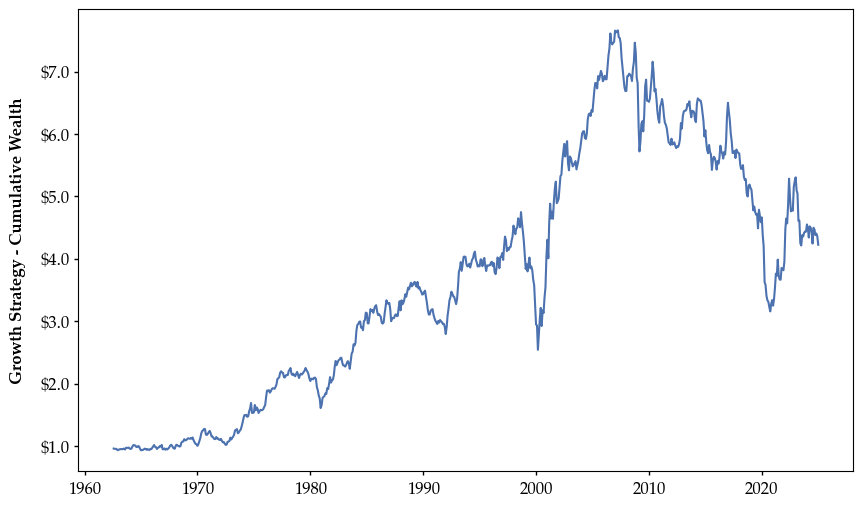

In [16]:
f, ax = plt.subplots(figsize = (10, 6))

sns.lineplot(data = sub, x = 'date', y = 'cumret_value', ax = ax)

ax.set_xlabel(None)
ax.set_ylabel('Growth Strategy - Cumulative Wealth', fontsize = 12, fontweight = 'bold', labelpad = 10)

# ax.xaxis.set_major_formatter(mdates.DateFormatter(r'%Y %b'))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:.1f}'))

plt.show()

## END